In [3]:
import matplotlib.pyplot as plt
import random as rdn
import numpy as np
import scipy
import math
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from iminuit import Minuit
import pandas as pd
import time 
from scipy.interpolate import interp1d
import math


#importation des donnés
df = pd.read_csv("fsigma8_data.dat", sep=";")

z_data = np.array((df['z'].copy()).tolist())
fsig8 = np.array((df['fsig8'].copy()).tolist())
fsig8_err_minus = np.array((df['fsig8_err_minus'].copy()).tolist())
fsig8_err_plus = np.array((df['fsig8_err_plus'].copy()).tolist())


def gamma(w,omega_m0,z):
    return   (3*(w-1))/(6*w-5) #- ((15/2057)*np.log(omega_m(z,omega_m0)))

def omega_m(z,omega_m0,w):
    return (omega_m0*(1/(omega_m0+(1-omega_m0)*(1+z)**(3*w))))

def omega_mGamma(z,gamma,omega_m0,w):
    return omega_m(z,omega_m0,w)**gamma

def func(z, omega_m0, w):
    return omega_mGamma(z, gamma(w, omega_m0, z), omega_m0, w) / (1 + z)

def D_z(omega_m0, z, w):
    result, _ = quad(func, 0, z, args=(omega_m0, w))
    return np.exp(-result)

def sigma8(sigma8_0, omega_m0, z, w):
    return sigma8_0 * np.array([D_z(omega_m0, zi, w) for zi in z])

def Chi2(omega_m0, sigma8_0, w):
    sigma8_vals = sigma8(sigma8_0, omega_m0, z_data, w)
    pred = omega_mGamma(z_data, gamma(w, omega_m0, z_data), omega_m0, w) * sigma8_vals

    residuals = fsig8 - pred
    sigma_errors = np.where(residuals >= 0, fsig8_err_plus, fsig8_err_minus)
    chi2_terms = (residuals / sigma_errors) ** 2

    return np.sum(chi2_terms)

list_w = [-1]
list_omega_m = []
list_sigma8_0 = []

for w in list_w:
    
    minimizer = Minuit(Chi2, omega_m0=0.3, sigma8_0=0.7,w=w)
    minimizer.limits["omega_m0"] = (0,1)
    minimizer.limits["sigma8_0"] = (0,1)  # Valeurs plus physiques
    minimizer.fixed["w"] = True
    minimizer.errordef = 1.0  # Pour chi2
    minimizer.strategy = 2    # Plus précis
    result = minimizer.migrad()
    
    # Statistiques du fit
    chi2_val = minimizer.fval
    ndof = len(fsig8) - len(minimizer.parameters)
    chi2_reduit = chi2_val / ndof

    list_omega_m.append(minimizer.values['omega_m0'])
    list_sigma8_0.append(minimizer.values['sigma8_0'])
    
    print(f"\nRésultats du fit pour w =",w)
    print(f"Chi2 = {chi2_val:.2f}")
    print(f"Nombre de degrés de liberté = {ndof}")
    print(f"Chi2 réduit = {chi2_reduit:.2f}")
    print(f"Paramètres estimés :")
    print(f"Ωm = {minimizer.values['omega_m0']:.3f} ± {minimizer.errors['omega_m0']:.3f}")
    print(f"σ8,0 = {minimizer.values['sigma8_0']:.3f} ± {minimizer.errors['sigma8_0']:.3f}")



Résultats du fit pour w = -1
Chi2 = 9.76
Nombre de degrés de liberté = 20
Chi2 réduit = 0.49
Paramètres estimés :
Ωm = 0.341 ± 0.060
σ8,0 = 0.761 ± 0.034


<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Redouane\AppData\Local\Temp\ipykernel_4396\1060057790.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Fit $f\sigma_8$ (approximation analytique)')


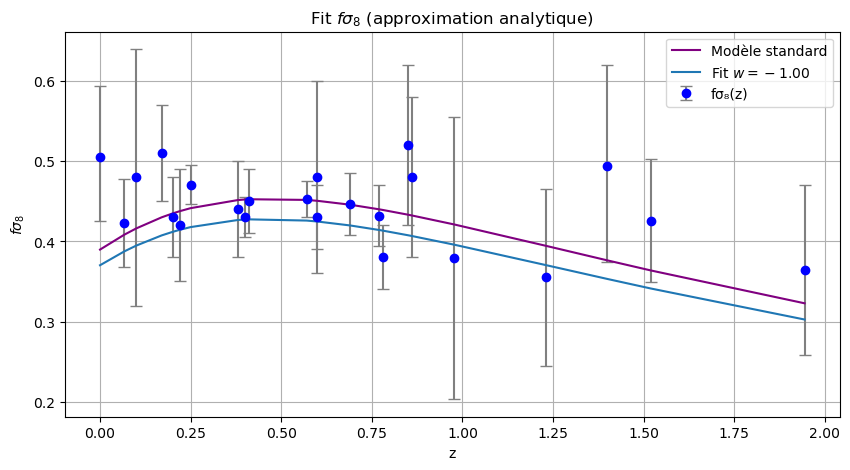

In [2]:
# Calcul du modèle ajusté sur les mêmes z que les données


gamma_modele_standard = gamma(0.334,-1,z_data)
modele_standard = omega_mGamma(z_data, gamma_modele_standard, 0.334,-1) * np.array([sigma8(0.81,0.334, z,-1) for z in z_data])

plt.figure(figsize=(10, 5))
plt.errorbar(z_data, fsig8, yerr=[fsig8_err_minus, fsig8_err_plus], fmt='o', ecolor='gray', elinewidth=1.5, capsize=4, label="fσ₈(z)", color='blue')
plt.plot(z_data, modele_standard, color='purple', linestyle='-', label='Modèle standard')

for i in range(len(list_w)):
    omega_m0_fit = list_omega_m[i]
    sigma8_0_fit = list_sigma8_0[i]
    w = list_w[i]
    gamma_fit = gamma(omega_m0_fit,w,z_data)
    modele = omega_mGamma(z_data, gamma_fit, omega_m0_fit,w) * np.array([sigma8(sigma8_0_fit, omega_m0_fit, z,w) for z in z_data]) 
    plt.plot(z_data, modele, '-',label=rf"Fit $w = {w:.2f}$")
    
plt.xlabel('z')
plt.ylabel(r'$f\sigma_8$')
plt.title('Fit $f\sigma_8$ (approximation analytique)')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
from tqdm import tqdm  # pour la barre de progression (facultatif)
N = 100
omega_m0_vals = np.linspace(0.15,0.75,N)
sigma8_0_vals = np.linspace(0.6,1,N)


# On va projeter sur chaque plan 2D en fixant le troisième paramètre à sa valeur best-fit
chi2_grid_om_si8 = np.zeros((len(omega_m0_vals), len(sigma8_0_vals)))


# Best-fit
om_best = minimizer.values['omega_m0']
sig8_best = minimizer.values['sigma8_0']
w_best = minimizer.values['w']


def compute_grid_Chi2(omega_vals, sigma_vals,w):
    # Ωm0 vs σ8 (w fixé)
    OM, Sig8 = np.meshgrid(omega_vals, sigma_vals, indexing='ij')
    chi2_grid_om_sig8 = np.vectorize(lambda om, sig8: Chi2(om, sig8,w))(OM, Sig8)
    return chi2_grid_om_sig8

# --- Calcul des grilles ---
print("Début du calcul des grilles χ² vectorisées...")


tab_grid = np.array([])

tab_grid = []
for w in tqdm(list_w, desc="Calcul des grilles"):
    start = time.time()
    
    # Calcul de la grille
    chi2_grid = compute_grid_Chi2(omega_m0_vals, sigma8_0_vals,w)
    
    tab_grid.append(chi2_grid)
    
    # Trouver le min dans la grille

    
    end = time.time()
    print(f"w = {w:.2f} : grille calculée en {end - start:.2f}s")



Début du calcul des grilles χ² vectorisées...


Calcul des grilles: 100%|██████████| 1/1 [00:10<00:00, 10.54s/it]

w = -1.00 : grille calculée en 10.54s


In [4]:
om_ms = 0.334
sig8_ms = 0.81 * (0.3 / om_ms) ** (0.5)

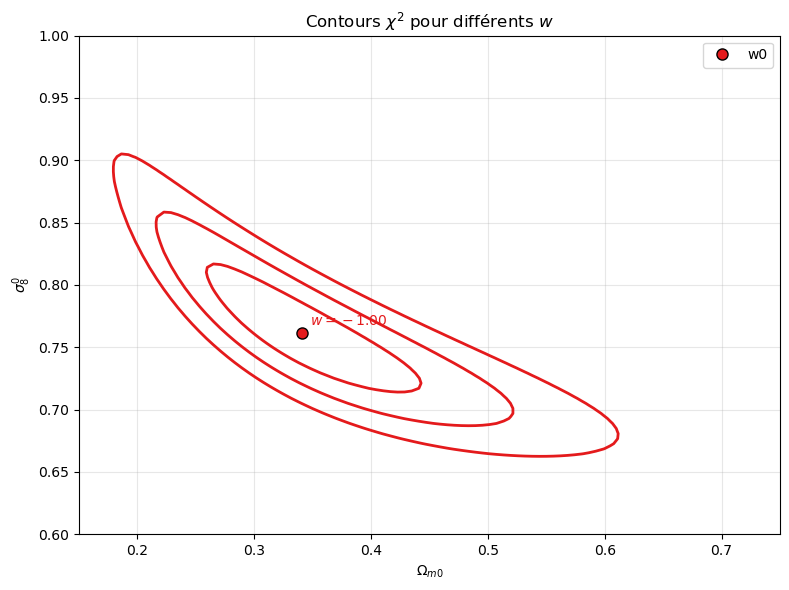

In [5]:
import matplotlib.pyplot as plt

# Niveaux de χ²
chi2_min = np.min([np.min(grid) for grid in tab_grid])
levels = [chi2_min + d for d in [2.30, 6.18, 11.83]]

fig, ax = plt.subplots(figsize=(8, 6))

# Contours du modèle standard

# Couleurs bien visibles
colors = plt.cm.Set1(np.linspace(0, 1, len(list_w)))

for i, (grid, w_val) in enumerate(zip(tab_grid, list_w)):
    ax.contour(omega_m0_vals, sigma8_0_vals, grid.T,levels=levels, colors=[colors[i]], linewidths=2)
    
    ax.plot(list_omega_m[i],list_sigma8_0[i], 'o', color=colors[i],label="w"+str(i), markersize=8, markeredgecolor='black')
    ax.annotate(rf"$w={w_val:.2f}$",(list_omega_m[i],list_sigma8_0[i]),textcoords="offset points",xytext=(6, 6),fontsize=10,color=colors[i],weight='bold')

# Mise en page
ax.set_xlabel(r"$\Omega_{m0}$")
ax.set_ylabel(r"$\sigma_8^0$")
ax.set_title(r"Contours $\chi^2$ pour différents $w$")
ax.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


